# figure illustrating $M_*$ completeness 
See `proSMF/nb/mstar_completeness.ipynb` for how it's computed

In [1]:
import os, pickle
import numpy as np
from tqdm.auto import trange
import astropy.table as aTable

from astropy import units as U
from astropy.cosmology import Planck13

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## $M_{\rm lim}$ calculation demonstration

In [16]:
with open(os.path.join(dat_dir, 'ms_comp.bgs_bright.demo.p'), 'rb') as fp:
    mstar_z0, in_z1 = pickle.load(fp)

/home/chhahn/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


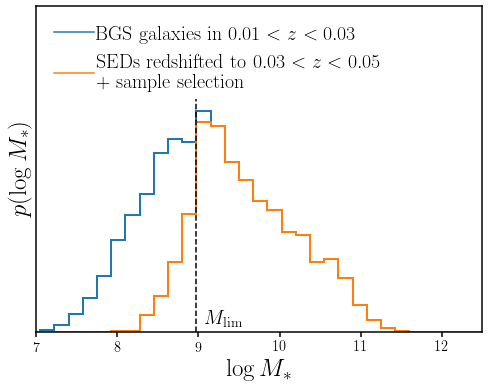

In [38]:
h0, edges = np.histogram(mstar_z0, range=(6, 13), bins=40)
h1, _ = np.histogram(mstar_z0[in_z1], range=(6, 13), bins=40)
fcomp = (h1/h0)
Mlim = (np.min(edges[:-1][(fcomp > 0.9) & (h0 > 5)]))


fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
_ = sub.hist(mstar_z0, range=(6, 13), bins=40, histtype='step', linewidth=2)
_ = sub.hist(mstar_z0[in_z1], range=(6, 13), bins=40, histtype='step', linewidth=2)

ymax = plt.gca().get_ylim()[1]
sub.plot([Mlim, Mlim], [0, ymax], color='k', linestyle='--') 
sub.text(Mlim+0.1, 10, r'$M_{\rm lim}$', fontsize=20)

#sub.plot(0.5*(edges[1:] + edges[:-1])[h0 > 5], (h1/h0)[h0 > 5] * ymax, c='k')
#sub.plot([edges[0], edges[-1]], [ymax, ymax], c='k', ls=':')

sub.plot([], [], c='C0', label=r'BGS galaxies in $%.2f < z < %.2f$' % (0.01, 0.03))
sub.plot([], [], c='C1', label='SEDs redshifted to $%.2f < z < %.2f$'% (0.03, 0.05)+'\n'+'+ sample selection')
sub.legend(loc='upper left', fontsize=20, handletextpad=0.1)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(7, 12.5)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yticks([])
sub.set_yticklabels([])
sub.set_ylim(0, 1.4*ymax)
plt.show()
#fig.savefig('../figs/psmf_logMstar_comp_demo.pdf', bbox_inches='tight')

## read PROVABGS-EDR catalog
Only keep BGS Bright galaxies with posteriors

In [3]:
dat_dir = '/tigress/chhahn/provabgs/svda'
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.hdf5'))
has_posterior = (bgs['provabgs_z_max'].data != -999.)
is_bgs_bright = bgs['is_bgs_bright']

bgs = bgs[has_posterior & is_bgs_bright]
print('%i BGS Bright galaxies with posteriors' % len(bgs))

143017 BGS Bright galaxies with posteriors


## read $\log M_*$ completeness limits
$M_{\rm lim}$ are defined in $z$ bins with half the width that we want. So we will double the $z$ width and use the larger $M_{\rm lim}$

In [4]:
zmins, zmaxs, Mlims = np.loadtxt(os.path.join(dat_dir, 'psmf.logmstar_comp_limit.dat'), 
                                 unpack=True, usecols=[0, 1, 2])

In [10]:
is_mass_complete = []
for i in range(8): 
    zlim0 = (bgs['Z_HP'].data > zmins[2*i]) & (bgs['Z_HP'].data < zmaxs[2*i+1])
    Mlim = Mlims[2*i+1]
    is_mass_complete.append(np.arange(len(bgs))[zlim0][bgs['provabgs_logMstar_bf'].data[zlim0] > Mlim])
is_mass_complete = np.concatenate(is_mass_complete)

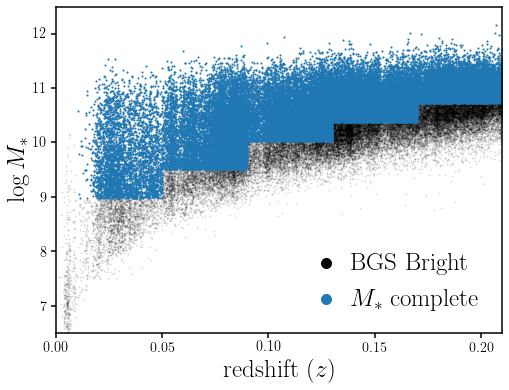

In [11]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z_HP'].data, bgs['provabgs_logMstar_bf'].data, c='k', s=1, alpha=0.1, rasterized=True)
sub.scatter([], [], c='k', s=1, label='BGS Bright')
sub.scatter(bgs['Z_HP'].data[is_mass_complete], bgs['provabgs_logMstar_bf'].data[is_mass_complete], c='C0', s=1, 
            label='$M_*$ complete', rasterized=True)
sub.legend(loc='lower right', markerscale=10, handletextpad=0., fontsize=25)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.21)
sub.set_xticks([0., 0.05, 0.1, 0.15, 0.2])
sub.set_ylabel(r"$\log M_*$", fontsize=25)
sub.set_ylim(6.5, 12.5)
fig.savefig('../figs/psmf_logMstar_comp_z.pdf', bbox_inches='tight')